## Actividad : Puerta de Ruido

* Realizar un script de python que cargue un archivo de sonido y genere como salida varios otros archivos de sonido aplicando una funcion compuerta de ruido[1] con los siguientes parametros configurables: 
    * Umbral de apertura: Es el valor que debe superarse para que se abra la compuerta.
    * Umbral de cierre: Es el valor que debe alcanzarse para volver a cerrarse
    * “hold”: Es el tiempo que permanece abierta la compuerta una vez alcanzado el umbral de cierre (si durante este periodo la señale quedara entre ambos umbrales, la compuerta permanecera abierta).
* Implementar la compuerta de ruido en C como embebido en el lazo.

In [1]:
# Importacion de librerias
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
from scipy.io import wavfile
import wave
from IPython.display import Audio

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns

/tmp/ipykernel_12338/462680925.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


In [2]:
# Leemos el archivo de texto que contiene los eventos de bite, chew, chewbite
df_classes = pd.read_csv("./datos/recording_12.txt", sep="\t", header=None, names= ['timeStart','timeEnd','Class'])

In [3]:
# Mostramos las primeras 10 lineas
df_classes.head(10)

,timeStart,timeEnd,Class
0,0.123994,0.723994,bite
1,0.941320,1.667091,bite
2,2.324402,3.364402,bite
3,3.920000,4.440000,bite
4,4.667856,5.267856,bite
5,5.480000,6.240000,chew
6,6.320000,6.960000,chew
7,7.160000,7.600000,bite
8,7.680000,8.440000,chew
9,8.520000,9.280000,chew


In [4]:
# Retorna los valores unicos de una serie de objetos
df_classes['Class'].unique()

array(['bite', 'chew', 'chewbite'], dtype=object)

Text(0.5, 1.0, 'Classes')

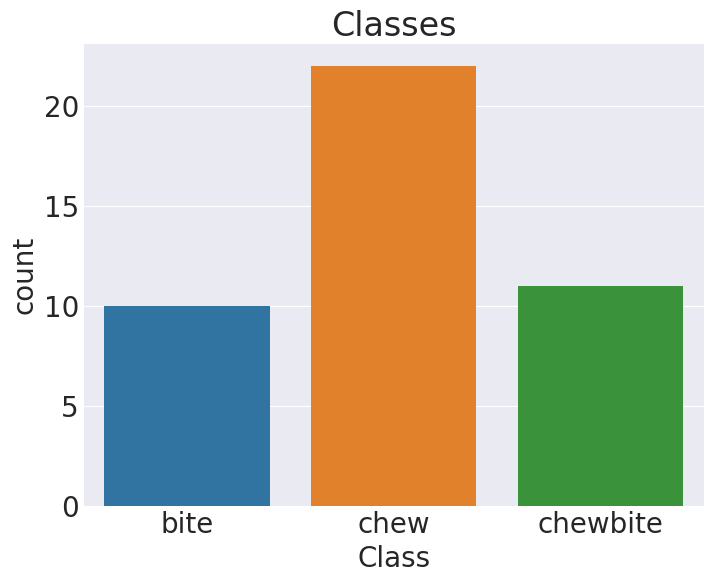

In [5]:
fig, ax = plt.subplots(1,figsize=(8,6))
sns.countplot(x='Class',data=df_classes)  
ax.set_title('Classes')

In [6]:
# Leemos el archivo de audio correlacionado con el archivo de texto con eventos
from time import time

samplerate, audio = wavfile.read("./datos/recording_12.wav")

audio_len = len(audio)
duration = audio_len / samplerate

# Imprimimos algunos datos de la lectura del wav
print(f"Cant. de muestras: {audio_len}")
print(f"Frecuencia de muestreo: {samplerate} Hz")
print(f"Duracion: {duration:.1f} segundos")


Cant. de muestras: 918354
Frecuencia de muestreo: 22050 Hz
Duracion: 41.6 segundos


/tmp/ipykernel_12338/3070107464.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, audio = wavfile.read("./datos/recording_12.wav")


In [7]:
# Leemos el archivo wav                                                                                             
ifile = wave.open("./datos/recording_12.wav")
samples = ifile.getnframes()
audioFrames = ifile.readframes(samples)

# Convertimos el buffer a float32 usando NumPy                                                                                 
audio_as_np_int16 = np.frombuffer(audioFrames, dtype=np.int16)
audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

# Normalizamos el array floar32 a valores entre -1.0 y 1.0                                                    
max_int16 = 2**15
audio_norm = audio_as_np_float32 / max_int16

t_audio = np.arange(audio_norm.shape[0]) / samplerate

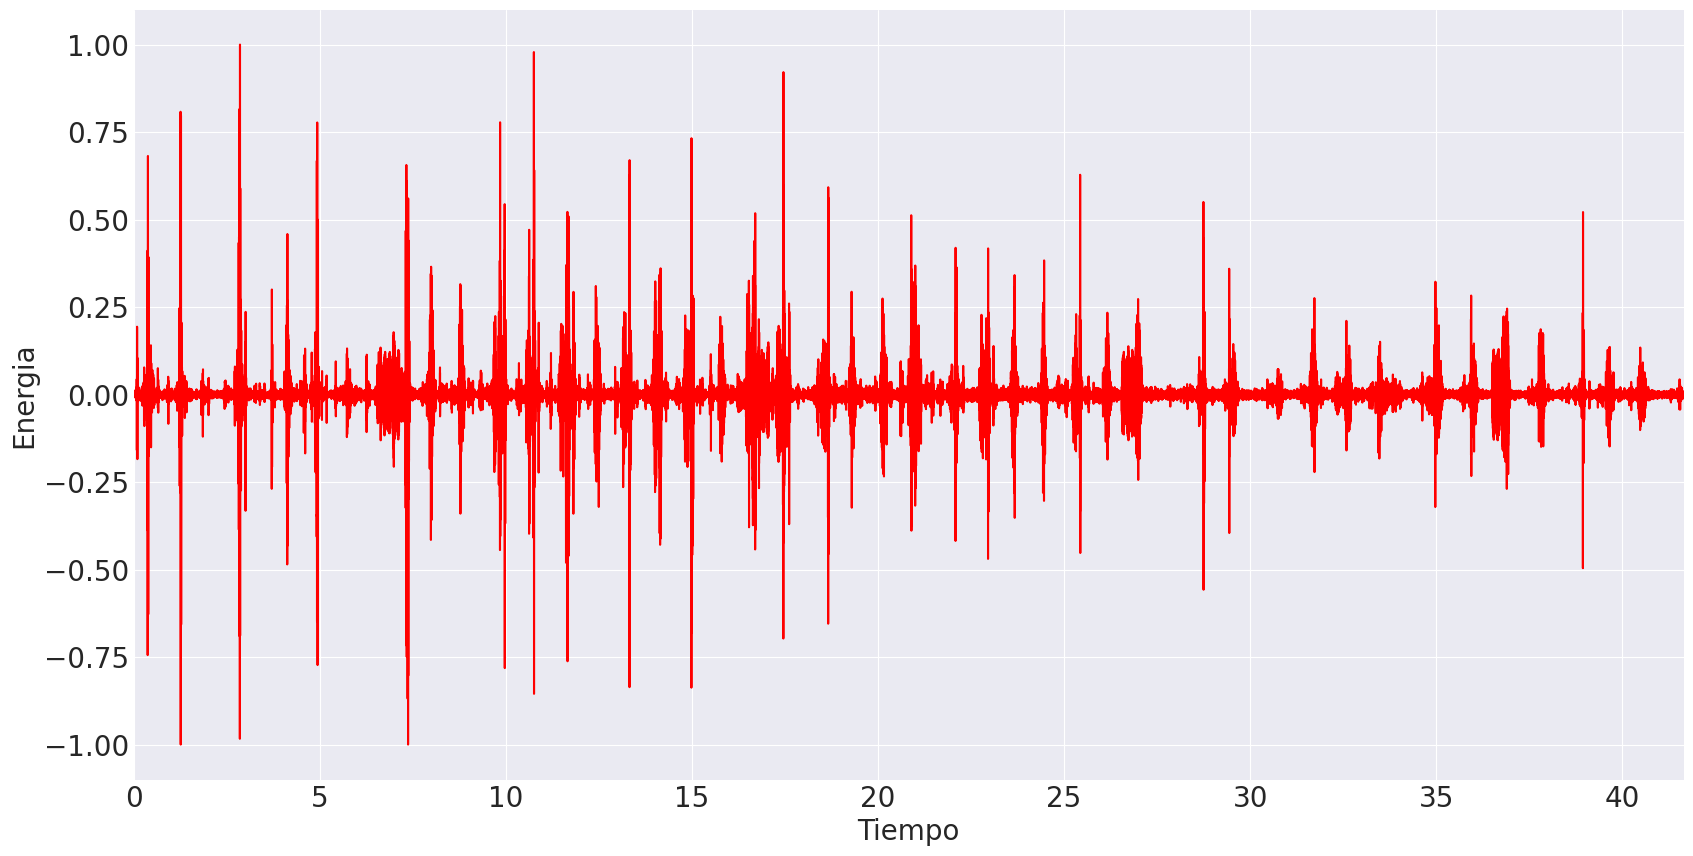

In [8]:
# Configuramos y ploteamos los datos, ubicando en el eje x el tiempo y en el eje y la energia de la onda
plt.figure(figsize=(20, 10))
plt.plot(t_audio, audio_norm, color='red')
plt.xlabel("Tiempo")
plt.xlim([0, duration])
plt.ylabel("Energia")
plt.show()

In [9]:
# Crea un objeto a partir de un dato crudo
Audio(audio_norm, rate=samplerate)

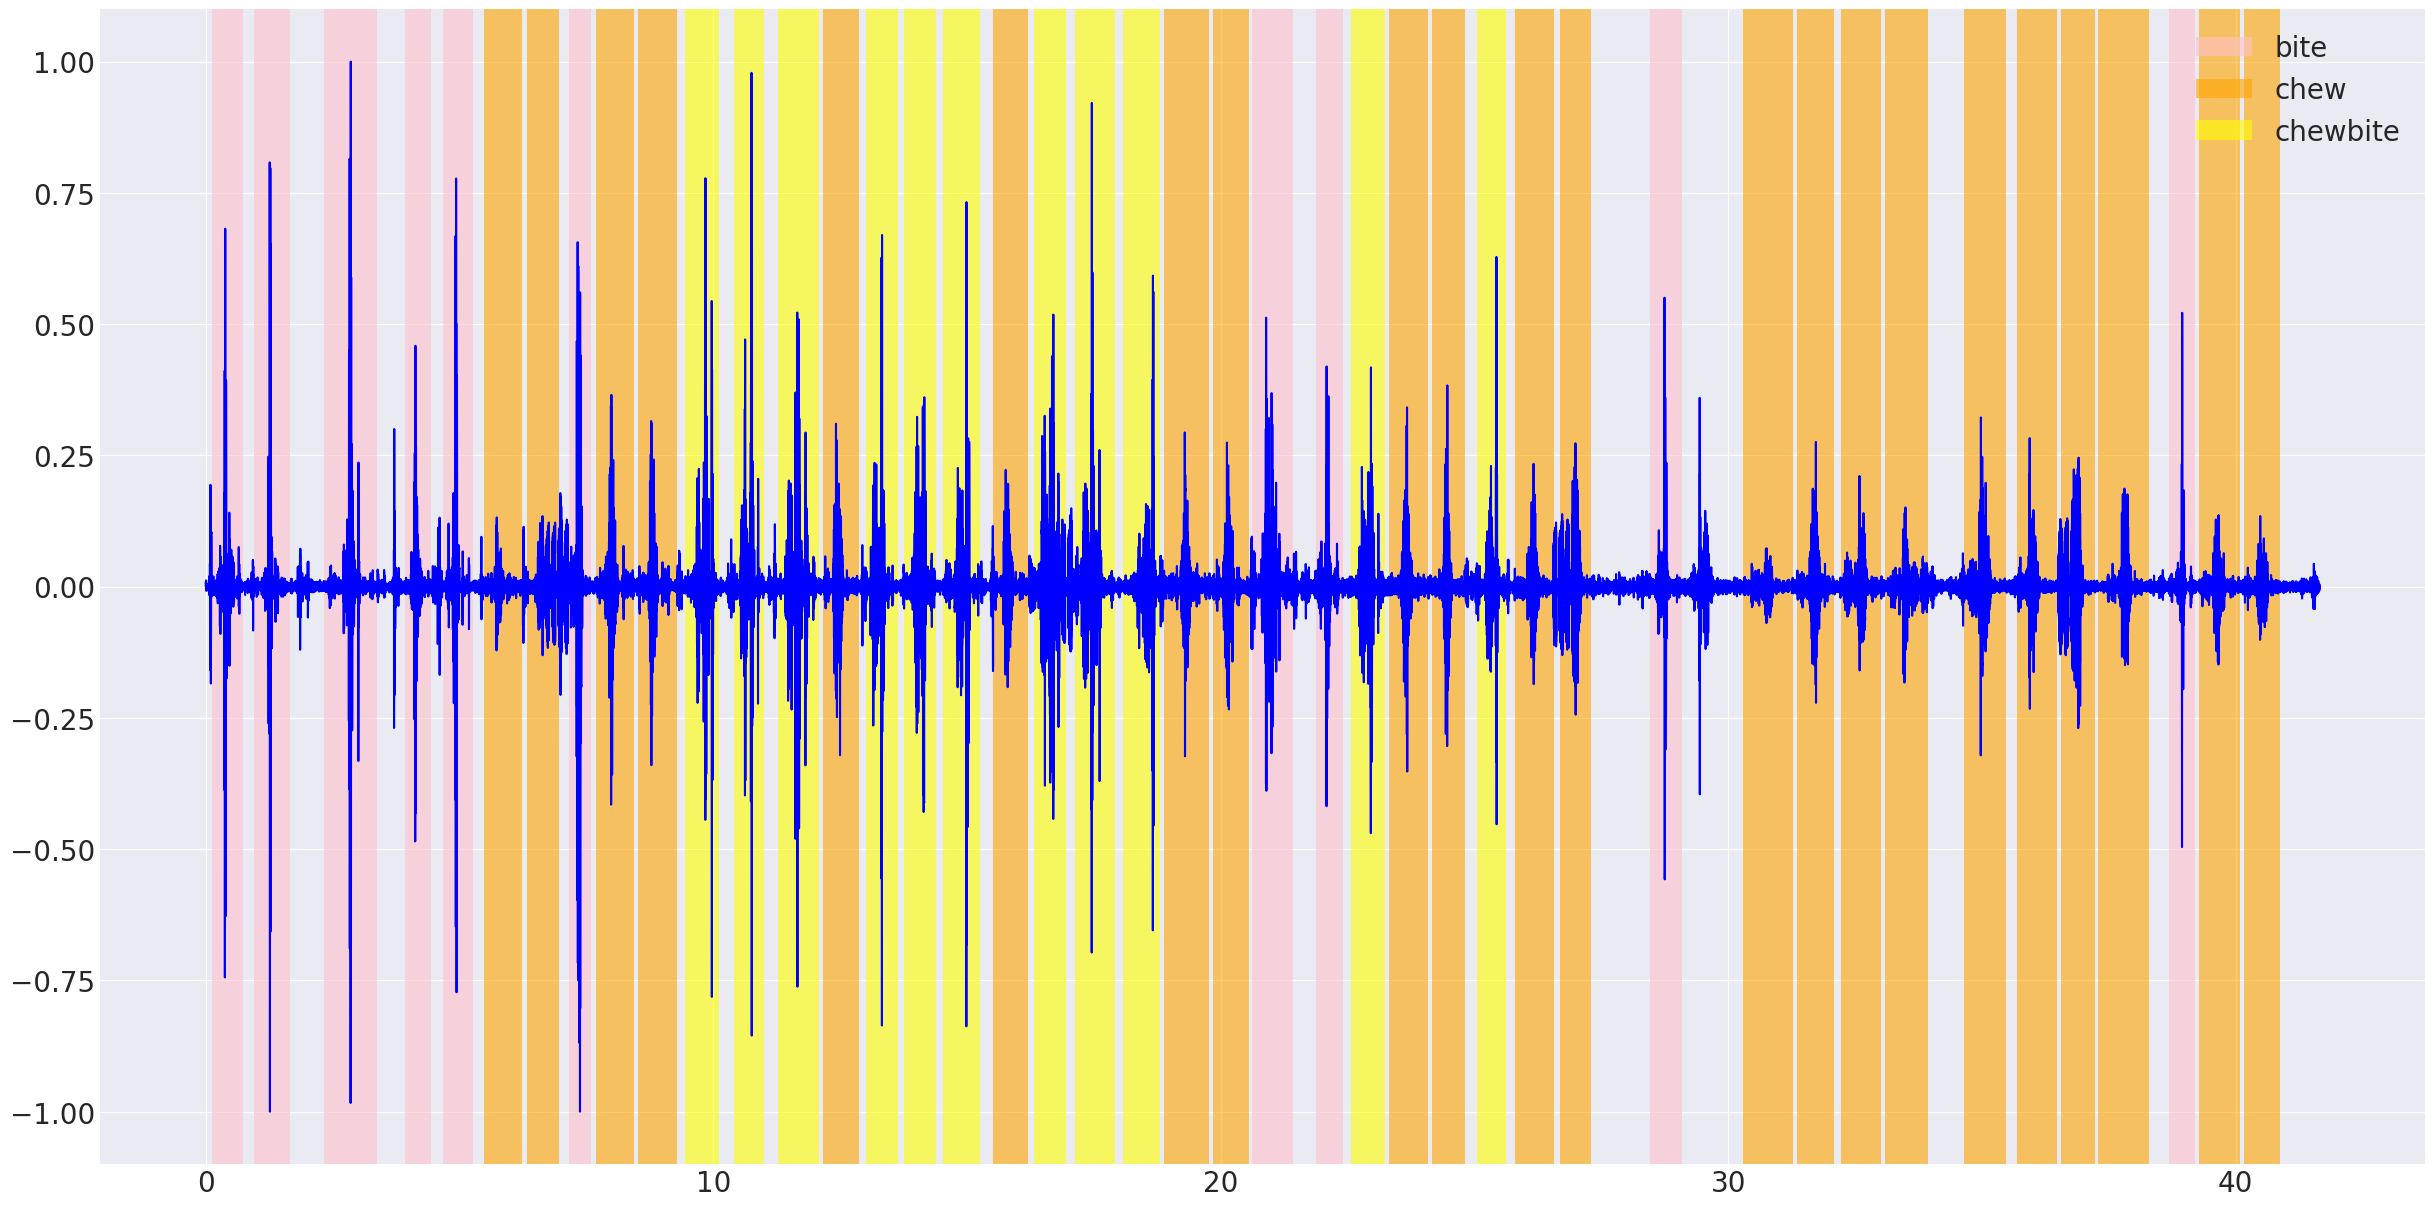

In [10]:
# Definimos los colores que utilizaremos en el grafico para indicacion de diferentes tipos de clases
colors = {
  "bite": "pink",
  "chewbite": "yellow",
  "chew": 'orange'
}

plt.figure(figsize=(30, 15))
plt.plot(t_audio, audio_norm, color='blue')

# Recorremos toda la lista de clases leidas desde el archivo de texto para poder agregar los indicadores 
# de tipo de clase
for idx in range(len(df_classes)):
  plt.axvspan(df_classes['timeStart'].iloc[idx], 
              df_classes['timeEnd'].iloc[idx], 
              color=colors[df_classes['Class'].iloc[idx]], 
              alpha=0.6, 
              lw=0, 
              label=df_classes['Class'].iloc[idx])

# Configuramos y ploteamos el gráfico
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

### Compuerta de ruido
Implementaremos un algoritmo de compuerta de ruido el cual tendrá como parametros de input los siguientes valores:
- open : umbral de apertura
- close : umbral de cierre
- hold : tiempo que permanece abierta la compuerta una vez alcanzado el umbral de cierre
- sampleRate : frecuencia de muestreo de la señal

/tmp/ipykernel_12338/3636169722.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  graph.show()


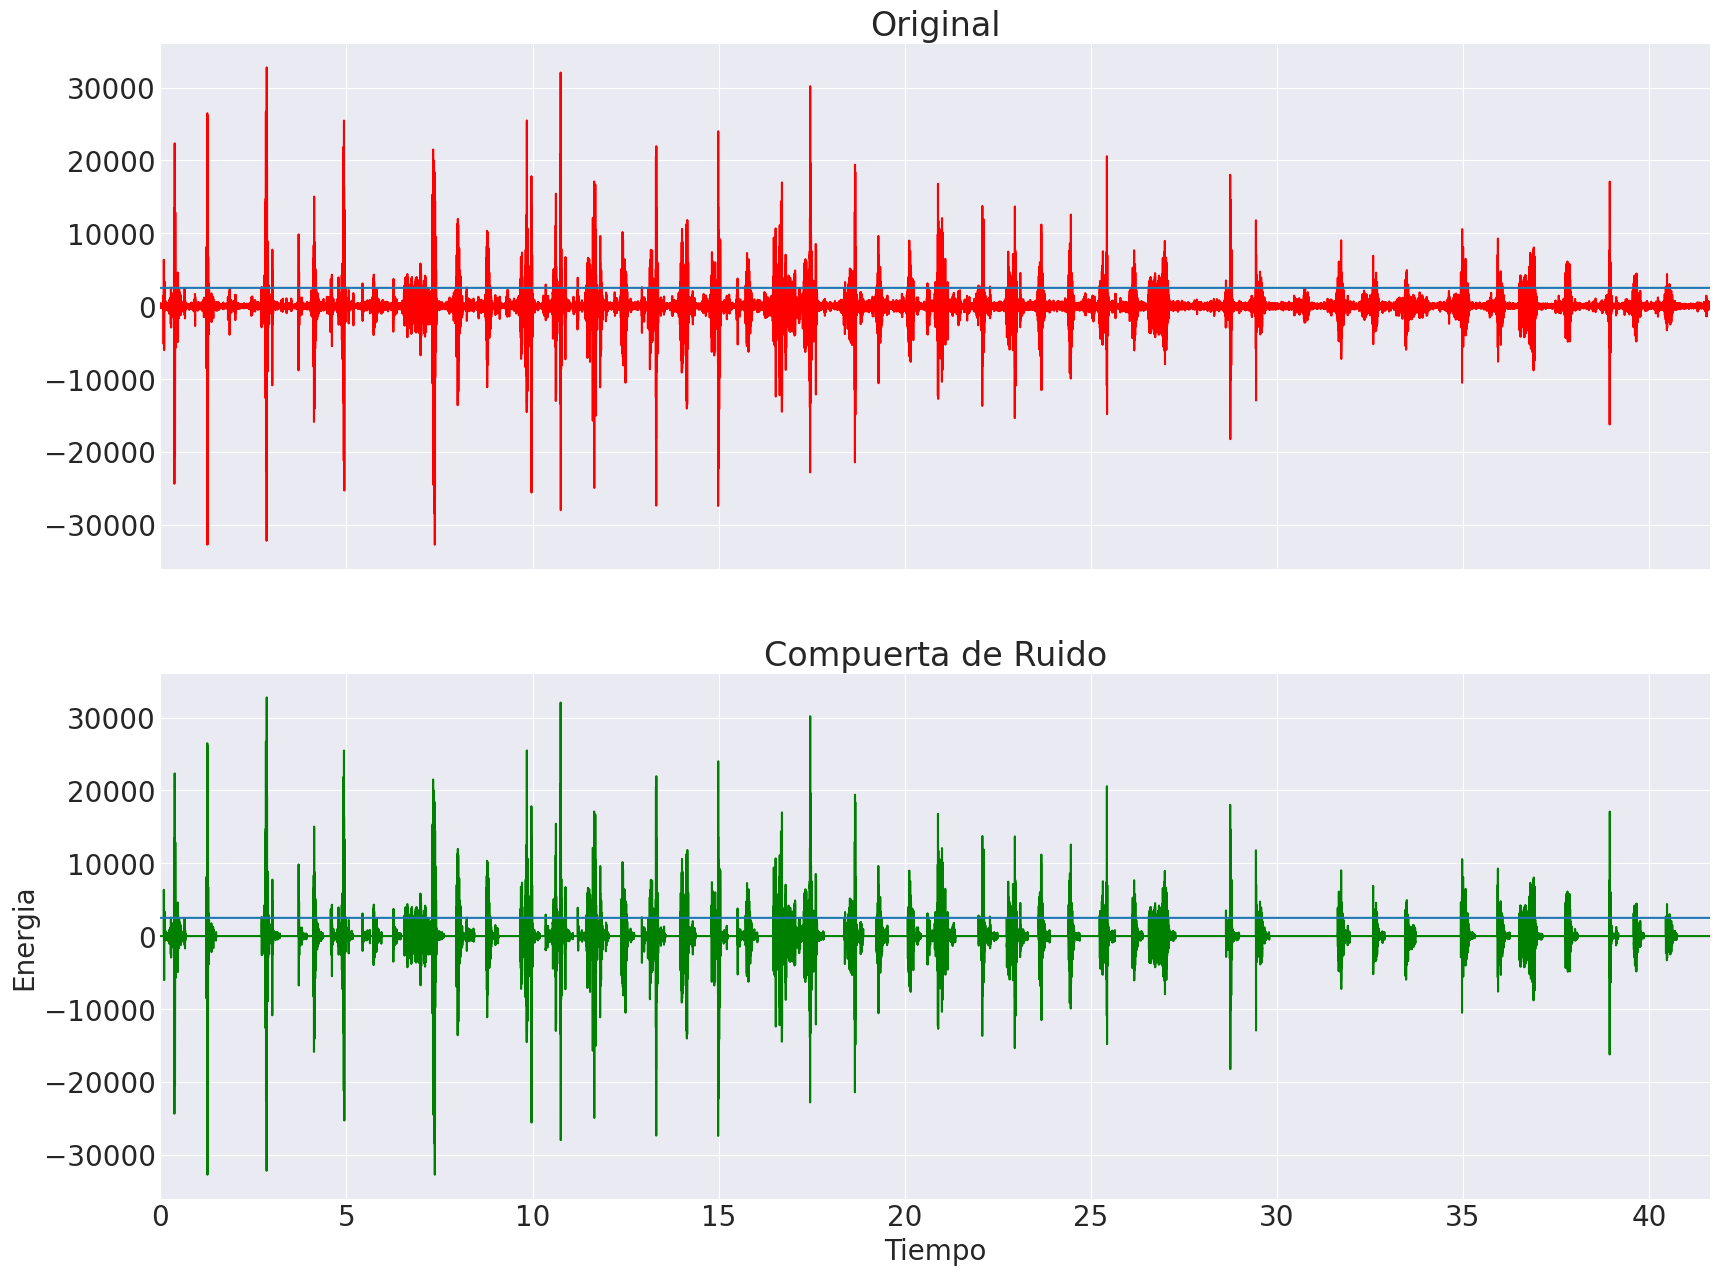

In [11]:
UMBRAL_APERTURA = 2500
UMBRAL_CIERRE = 200
HOLD = 0.2

puertaDeRuido = []

counterOpen = 0
isOpen = False

# Recorro toda la lista con los elementos del audio y se implementa
# la puerta de ruido
for value in audio:    
    sample_uint = value + 32768

    if sample_uint >= UMBRAL_APERTURA + 32768:
        isOpen = True
        counterOpen = 0
    elif isOpen:
        if sample_uint < UMBRAL_CIERRE + 32768 and counterOpen >= int(HOLD * samplerate):
            isOpen = False
        else:
            counterOpen += 1
    
    # Agrego el elemento a la lista de valores
    puertaDeRuido.append(value if isOpen else 0)

# Defino el umbral para el grafico
threshold = np.ones_like(audio) * UMBRAL_APERTURA

graph, axes = plt.subplots(2, sharex=True, figsize=(20, 15))

# Devuelve números espaciados uniformemente en un intervalo específico.
timeline = np.linspace(0, duration, num=audio_len)

# Grafico los datos
axes[0].plot(timeline, audio, color='red')
axes[0].plot(timeline, threshold)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")
axes[1].set_ylabel("Energia")
axes[1].set_xlabel("Tiempo")

axes[1].plot(timeline, puertaDeRuido, color='green')
axes[1].plot(timeline, threshold)
axes[1].set_xlim([0, duration])
axes[1].set_title("Compuerta de Ruido")
axes[1].set_ylabel("Energia")
axes[1].set_xlabel("Tiempo")
 
graph.show()

Ahora implementaremos un algoritmo en C para realizar la misma aplicacion que hicimos en Python

/tmp/ipykernel_12338/241990664.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  graph.show()


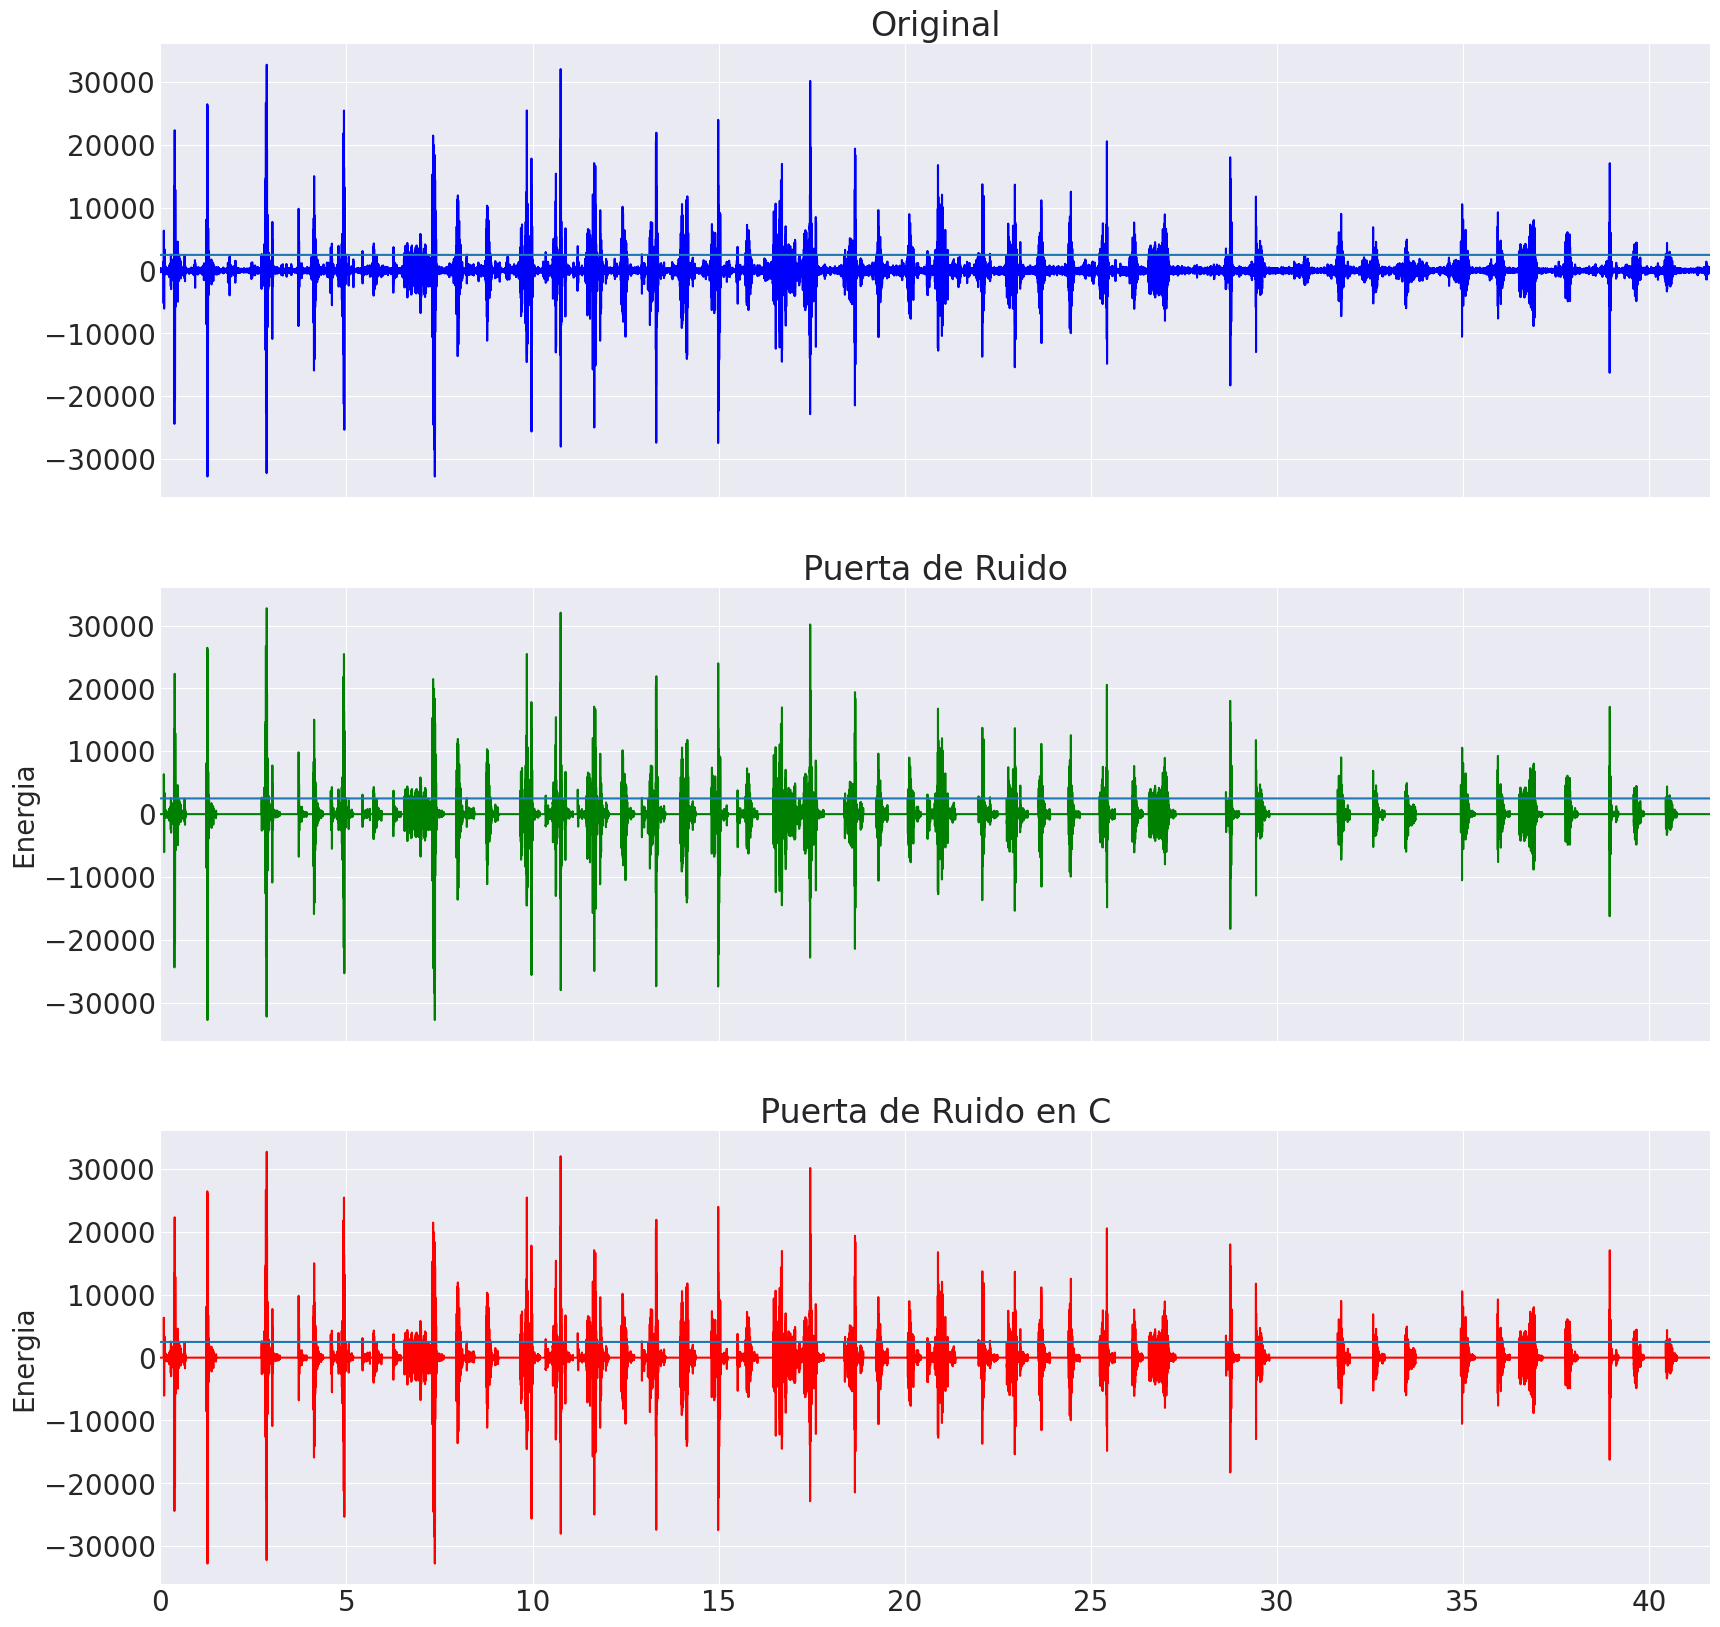

In [12]:
# Importacion de librerias necesarias para la generacion de la funcion de C y poder usarla en Python
from ctypes import CDLL, Structure, c_int, c_uint16, c_uint32, c_bool, POINTER
import os

# Declaracion de la estructura Config utilizada en la funcion en C
class Config(Structure):
    _fields_ = [
        ("open", c_uint16),
        ("close", c_uint16),
        ("samplesHold", c_uint32),
        ("openCounter", c_uint32),
        ("isOpen", c_bool),
    ]

# Generacion de la libreria en C para usar en Python
library_path = os.path.join("./librerias/funcion.c")
library_path_obj = os.path.join("./librerias/funcion.so")

!gcc -fPIC -shared -o $library_path_obj $library_path

cfunctions = CDLL(library_path_obj)

c_to_uint16 = cfunctions.toUint16
c_to_uint16.argtypes = [c_int]
c_to_uint16.restype = c_uint16

puertaDeRuidoFncC = cfunctions.puertaDeRuido
puertaDeRuidoFncC.argtypes = [c_uint16, POINTER(Config)]
puertaDeRuidoFncC.restype = c_bool

# Declaracion de la structura con los valores iniciales para pasalos
# a la funcion en C
config = Config(open=c_to_uint16(UMBRAL_APERTURA),
       close=c_to_uint16(UMBRAL_CIERRE),
       samplesHold=int(HOLD * samplerate),
       openCounter=0,
       isOpen=False)

puertaDeRuidoC = []

# Recorro toda la lista con los elementos del audio y se implementa
# la puerta de ruido
for value in audio:
    is_open = puertaDeRuidoFncC(c_to_uint16(value), config)
    
    # Agrego el elemento a la lista de valores
    puertaDeRuidoC.append(value if is_open else 0)


graph, axes = plt.subplots(3, sharex=True, figsize=(20, 20))

axes[0].plot(timeline, audio, color='blue')
axes[0].plot(timeline, threshold)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(timeline, puertaDeRuido, color='green')
axes[1].plot(timeline, threshold)
axes[1].set_xlim([0, duration])
axes[1].set_title("Puerta de Ruido")
axes[1].set_ylabel("Energia")

axes[2].plot(timeline, puertaDeRuidoC, color='red')
axes[2].plot(timeline, threshold)
axes[2].set_xlim([0, duration])
axes[2].set_title("Puerta de Ruido en C")
axes[2].set_ylabel("Energia")

graph.show()


In [13]:
# Corroboramos que son los mismos valores obtenidos en Python y en C
np.array_equal(puertaDeRuido, puertaDeRuidoC)

True

In [39]:
# Importacion de librerias para la comunicacion con la placa STM32
import serial
import time

# Inicializacion del puerto utilizado y la velocidad bps
PORT = "/dev/ttyACM0"
BAUD_RATE = 115200

# Samples utilizados para la comunicacion
SAMPLES = 20

# Inicializacion de la comunicacion del puerto con los parametros
serial_port = serial.Serial(port=PORT, 
                            baudrate=BAUD_RATE, 
                            timeout=0.1)

# Borra todo el contenido del buffer de comunicacion
serial_port.flushInput()

stm32Response = []

for value in audio[:SAMPLES]:    
    data_uint = int(value) + 32768   
    serial_port.write(data_uint.to_bytes(2, "little"))
    bytes = serial_port.read(2)   
    result = int.from_bytes(bytes, "little")
    result -= 32768
    stm32Response.append(result) 

serial_port.close()

In [40]:
np.array_equal(stm32Response, puertaDeRuidoC[:SAMPLES])

print(stm32Response)

print(puertaDeRuidoC[:SAMPLES])


[-29390, -3574, -7323, -13194, -4507, -24544, -29390, -3574, -7323, -13194, -4507, -24544, -29390, -3574, -7323, -13194, -4507, -24544, -29390, -3574]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
